# Making best vgg16 net (hyperparameter tuning on 8 epochs and analyzing the results)

In [2]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [27]:
RANDOM_STATE = 1234

In [28]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [29]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [30]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols,dense_size,dropout_rate,extra_layers):
    base_model = VGG16(include_top=False,
                      input_shape = (img_rows,img_cols,3),
                      weights = 'imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
#     increasing this dense layer size we get more overfitted model
    model.add(Dense(dense_size,activation='relu'))
    model.add(Dropout(dropout_rate))
#     add 2 more layers
    if(extra_layers):
        model.add(Dense(dense_size / 2,activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [31]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:01<00:00, 171.99it/s]


In [32]:
# shape of image
X[0].shape

(150, 150, 3)

In [33]:
len(X),len(Z)

(4947, 4947)

In [34]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [35]:
Y = to_categorical(Y,25)

In [36]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [37]:
# data scaling
X = np.array(X)
X = X.astype('float32')
X=X/255

In [38]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [39]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [40]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(x_train)

In [41]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [42]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [43]:
# dense size 1024 already included in base vgg16
dense_sizes = [2048,3072,4096]
epochs_test_size = 8
droput_sizes = [0.3,0.35,0.4,0.45]
extra_layers = [True,False]
# add hyperparameters to tune... learning_rates = [0.1,0.01,0.001...], batch_sizes[32,64,128...] ...
# add model analysis like confusion matrices, evaluation on test data ...
# only this was done due to hardware restrictions
for ds in dense_sizes:
    for drs in droput_sizes:
        for l in extra_layers:
            csvlogger = CSVLogger(
                filename= "finalVgg16NetLogs/" + "DenS" + str(ds) + "DropS" + str(drs) + "ExL" + str(l),
                separator = ",",
                append = False
            )

            # Reduce learning rate when a metric has stopped improving
            reduce = ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=2,
                verbose=1, 
                mode='auto'
            )

            callbacks = [csvlogger, reduce]
            model = vgg16_model(img_rows,img_cols,ds,drs,l)
            model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

            history = model.fit(
                                augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                                epochs = epochs_test_size,
                                verbose = 1,
                                validation_data  = augs_gen.flow(x_train, y_train, batch_size=16, subset='validation'),
                                callbacks=callbacks
                                )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dropout_7 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 25)               

76/76 [==============================] - 254s 3s/step - loss: 2.8538 - accuracy: 0.1778 - val_loss: 2.4400 - val_accuracy: 0.3237
Epoch 2/8
76/76 [==============================] - 254s 3s/step - loss: 2.2827 - accuracy: 0.3399 - val_loss: 2.2093 - val_accuracy: 0.3565
Epoch 3/8
76/76 [==============================] - 254s 3s/step - loss: 2.0563 - accuracy: 0.3886 - val_loss: 2.0564 - val_accuracy: 0.4104
Epoch 4/8
76/76 [==============================] - 253s 3s/step - loss: 1.8753 - accuracy: 0.4377 - val_loss: 1.9612 - val_accuracy: 0.4287
Epoch 5/8
76/76 [==============================] - 254s 3s/step - loss: 1.7666 - accuracy: 0.4600 - val_loss: 1.8893 - val_accuracy: 0.4403
Epoch 6/8
76/76 [==============================] - 253s 3s/step - loss: 1.6847 - accuracy: 0.4905 - val_loss: 1.8901 - val_accuracy: 0.4489
Epoch 7/8
76/76 [==============================] - 253s 3s/step - loss: 1.5802 - accuracy: 0.5194 - val_loss: 1.7896 - val_accuracy: 0.4855
Epoch 8/8
76/76 [=============

Epoch 1/8
76/76 [==============================] - 254s 3s/step - loss: 2.7923 - accuracy: 0.1869 - val_loss: 2.4526 - val_accuracy: 0.3073
Epoch 2/8
76/76 [==============================] - 254s 3s/step - loss: 2.2131 - accuracy: 0.3399 - val_loss: 2.1832 - val_accuracy: 0.3603
Epoch 3/8
76/76 [==============================] - 255s 3s/step - loss: 1.9664 - accuracy: 0.4134 - val_loss: 2.0459 - val_accuracy: 0.4037
Epoch 4/8
76/76 [==============================] - 254s 3s/step - loss: 1.7587 - accuracy: 0.4773 - val_loss: 1.9213 - val_accuracy: 0.4306
Epoch 5/8
76/76 [==============================] - 254s 3s/step - loss: 1.6640 - accuracy: 0.4983 - val_loss: 1.9143 - val_accuracy: 0.4528
Epoch 6/8
76/76 [==============================] - 254s 3s/step - loss: 1.5410 - accuracy: 0.5375 - val_loss: 1.8595 - val_accuracy: 0.4393
Epoch 7/8
76/76 [==============================] - 254s 3s/step - loss: 1.4556 - accuracy: 0.5606 - val_loss: 1.7597 - val_accuracy: 0.4836
Epoch 8/8
76/76 [===

Epoch 1/8
76/76 [==============================] - 295s 4s/step - loss: 2.7961 - accuracy: 0.1922 - val_loss: 2.4003 - val_accuracy: 0.3208
Epoch 2/8
76/76 [==============================] - 296s 4s/step - loss: 2.2530 - accuracy: 0.3329 - val_loss: 2.1573 - val_accuracy: 0.3805
Epoch 3/8
76/76 [==============================] - 321s 4s/step - loss: 2.0045 - accuracy: 0.4010 - val_loss: 2.0406 - val_accuracy: 0.3969
Epoch 4/8
76/76 [==============================] - 322s 4s/step - loss: 1.8388 - accuracy: 0.4559 - val_loss: 2.0500 - val_accuracy: 0.3873
Epoch 5/8
76/76 [==============================] - 312s 4s/step - loss: 1.7032 - accuracy: 0.4818 - val_loss: 1.9230 - val_accuracy: 0.4461
Epoch 6/8
76/76 [==============================] - 267s 4s/step - loss: 1.5918 - accuracy: 0.5248 - val_loss: 1.8030 - val_accuracy: 0.4788
Epoch 7/8
76/76 [==============================] - 264s 3s/step - loss: 1.5357 - accuracy: 0.5285 - val_loss: 1.8840 - val_accuracy: 0.4557
Epoch 8/8
76/76 [===

76/76 [==============================] - 268s 4s/step - loss: 2.9467 - accuracy: 0.1621 - val_loss: 2.4772 - val_accuracy: 0.2938
Epoch 2/8
76/76 [==============================] - 268s 4s/step - loss: 2.3939 - accuracy: 0.2768 - val_loss: 2.2124 - val_accuracy: 0.3507
Epoch 3/8
76/76 [==============================] - 268s 4s/step - loss: 2.1580 - accuracy: 0.3556 - val_loss: 2.0572 - val_accuracy: 0.4017
Epoch 4/8
76/76 [==============================] - 268s 4s/step - loss: 2.0308 - accuracy: 0.3709 - val_loss: 2.1548 - val_accuracy: 0.3622
Epoch 5/8
76/76 [==============================] - 267s 4s/step - loss: 1.9017 - accuracy: 0.4088 - val_loss: 2.0210 - val_accuracy: 0.4085
Epoch 6/8
76/76 [==============================] - 266s 4s/step - loss: 1.7907 - accuracy: 0.4608 - val_loss: 1.8634 - val_accuracy: 0.4432
Epoch 7/8
76/76 [==============================] - 284s 4s/step - loss: 1.6712 - accuracy: 0.4856 - val_loss: 1.7931 - val_accuracy: 0.4644
Epoch 8/8
76/76 [=============

In [138]:
def plot_acc_loss(acc,loss,val_acc,val_loss,num_of_epochs,f):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss:' + f)
    plt.plot(np.arange(0, num_of_epochs), loss, label='train')
    plt.plot(np.arange(0, num_of_epochs), val_loss, label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy:' + f)
    plt.plot(np.arange(0, num_of_epochs), acc, label='train')
    plt.plot(np.arange(0, num_of_epochs), val_acc, label='val')
    plt.legend(loc='best')

    plt.show()
    
#     print("acc:" + str(acc) + "\n")
#     print("val_acc:" + str(val_acc) + "\n")
#     print("loss:" + str(loss) + "\n")
#     print("val_loss:" + str(val_loss) + "\n")

In [139]:
epochs_test_size = 8
data = {}
for f in os.listdir("finalVgg16NetLogs"):
    data[str(f)] = pd.read_csv("finalVgg16NetLogs/" + f)

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.181106  2.829321      0.341040  2.414048
1      1  0.340347  2.248514      0.362235  2.198461
2      2  0.410891  1.968362      0.384393  2.061244
3      3  0.434406  1.847465      0.420039  1.950614
4      4  0.487211  1.684436      0.478805  1.791890
5      5  0.514026  1.601033      0.473988  1.833568
6      6  0.537129  1.508373      0.500000  1.729009
7      7  0.567657  1.434535      0.494220  1.775947


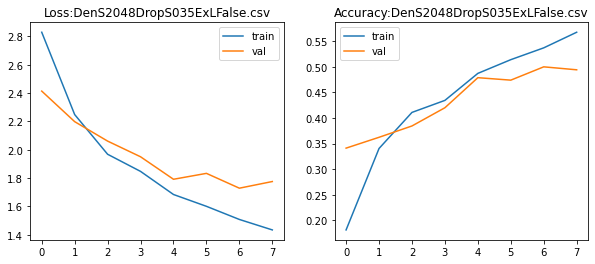

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.159653  2.922890      0.255299  2.557207
1      1  0.269389  2.383112      0.306358  2.256899
2      2  0.358498  2.132326      0.383430  2.101419
3      3  0.412129  1.955189      0.413295  1.979844
4      4  0.459571  1.821315      0.438343  1.905051
5      5  0.474835  1.726113      0.447013  1.857366
6      6  0.513614  1.606258      0.462428  1.834514
7      7  0.538779  1.511482      0.479769  1.830243


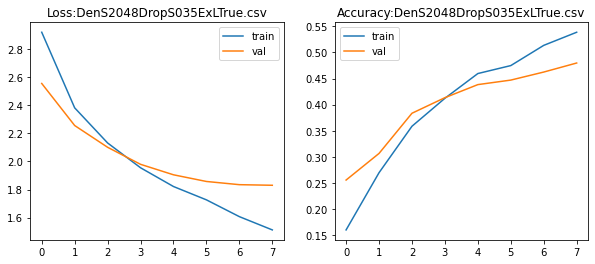

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.204620  2.788762      0.293834  2.423214
1      1  0.371287  2.168932      0.400771  2.104360
2      2  0.426980  1.953669      0.415222  1.986017
3      3  0.467822  1.772763      0.429672  1.941363
4      4  0.500825  1.652030      0.465318  1.876467
5      5  0.510726  1.593526      0.453757  1.874849
6      6  0.556518  1.486228      0.471098  1.780936
7      7  0.576733  1.399983      0.473025  1.792822


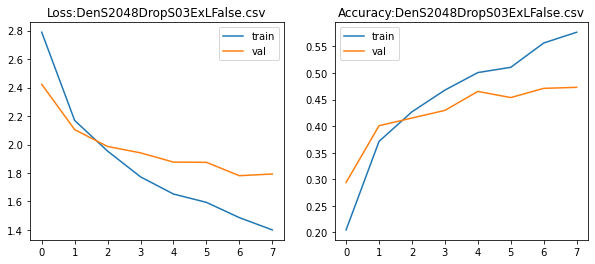

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.163779  2.891092      0.285164  2.444777
1      1  0.292492  2.331710      0.321773  2.248190
2      2  0.364274  2.081612      0.391137  2.064139
3      3  0.409241  1.924671      0.372832  2.043444
4      4  0.470710  1.739412      0.412331  1.915172
5      5  0.476485  1.679936      0.455684  1.826617
6      6  0.510726  1.582299      0.461464  1.892542
7      7  0.533828  1.482929      0.477842  1.742499


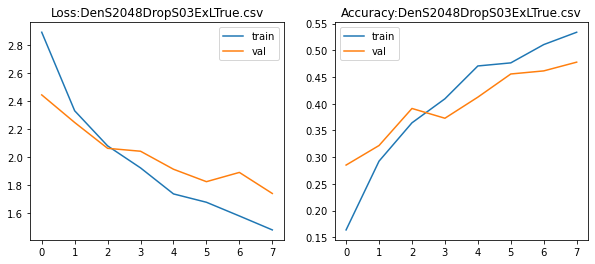

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.177805  2.853755      0.323699  2.439982
1      1  0.339934  2.282719      0.356455  2.209347
2      2  0.388614  2.056271      0.410405  2.056370
3      3  0.437706  1.875324      0.428709  1.961219
4      4  0.459983  1.766597      0.440270  1.889309
5      5  0.490512  1.684686      0.448940  1.890079
6      6  0.519389  1.580217      0.485549  1.789633
7      7  0.529703  1.537335      0.481696  1.748686


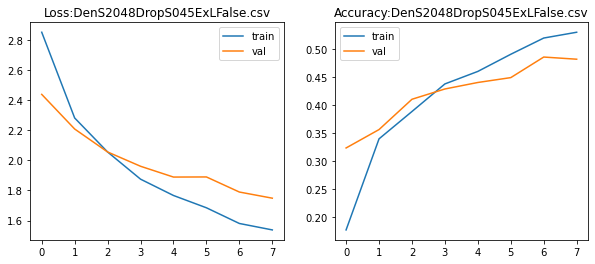

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.126238  3.032172      0.234104  2.621139
1      1  0.254538  2.514976      0.286127  2.350275
2      2  0.309406  2.267479      0.325626  2.235679
3      3  0.372112  2.097956      0.376686  2.065069
4      4  0.396865  1.991576      0.396917  2.036156
5      5  0.436469  1.881755      0.439306  1.891535
6      6  0.469059  1.786432      0.441233  1.884890
7      7  0.483086  1.681422      0.482659  1.841315


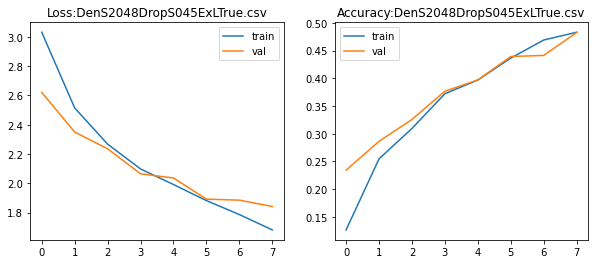

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.190182  2.809465      0.338150  2.455361
1      1  0.343647  2.226329      0.372832  2.171227
2      2  0.400990  2.007839      0.406551  2.033454
3      3  0.461634  1.814026      0.448940  1.918245
4      4  0.481023  1.728032      0.449904  1.879062
5      5  0.518152  1.618704      0.474952  1.789741
6      6  0.535479  1.527926      0.468208  1.819580
7      7  0.537954  1.487060      0.486513  1.752121


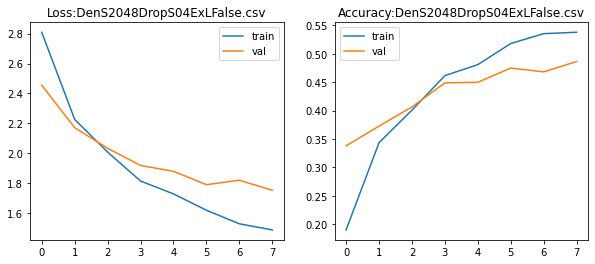

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.144389  2.994580      0.252408  2.575654
1      1  0.275990  2.435218      0.336224  2.276110
2      2  0.340347  2.164809      0.377649  2.112432
3      3  0.405116  2.003452      0.400771  2.004452
4      4  0.422442  1.897454      0.413295  2.007437
5      5  0.449257  1.786540      0.461464  1.846425
6      6  0.485561  1.711805      0.435453  1.898618
7      7  0.512789  1.630475      0.468208  1.802554


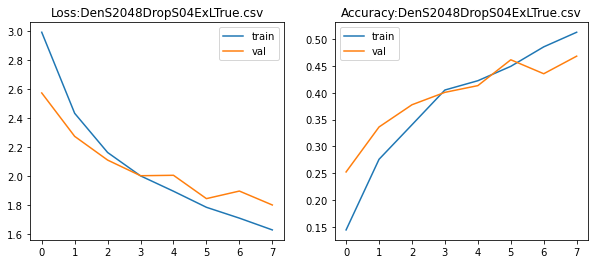

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.186881  2.792326      0.307322  2.452609
1      1  0.339934  2.213134      0.360308  2.183227
2      2  0.413366  1.966374      0.403661  2.045910
3      3  0.477310  1.758741      0.430636  1.921282
4      4  0.498350  1.664021      0.452794  1.914254
5      5  0.537541  1.540999      0.439306  1.859509
6      6  0.560644  1.455610      0.483622  1.759730
7      7  0.568069  1.398548      0.496146  1.748794


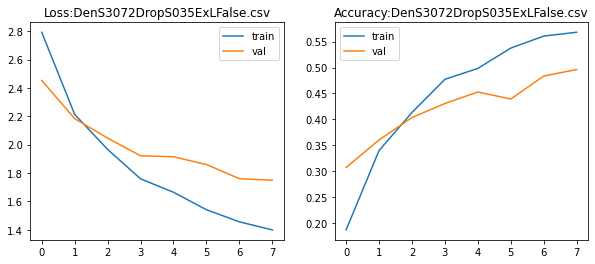

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.155528  2.924155      0.248555  2.477855
1      1  0.266914  2.390406      0.315992  2.265406
2      2  0.353135  2.123173      0.382466  2.059155
3      3  0.415429  1.938310      0.390173  1.999499
4      4  0.451733  1.819479      0.442197  1.928385
5      5  0.497112  1.666838      0.443160  1.887171
6      6  0.499175  1.575531      0.460501  1.806298
7      7  0.531353  1.501021      0.464355  1.820355


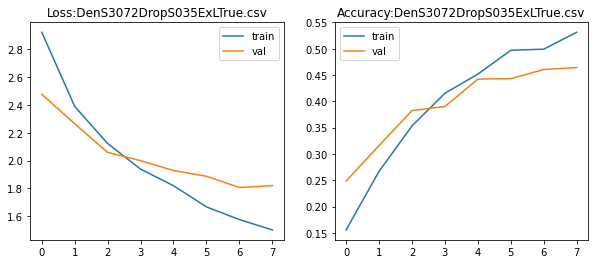

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.205446  2.744697      0.279383  2.432518
1      1  0.356436  2.199828      0.301541  2.251971
2      2  0.452970  1.878117      0.416185  2.038318
3      3  0.476485  1.753396      0.444123  1.911978
4      4  0.516089  1.619167      0.468208  1.861547
5      5  0.546205  1.499618      0.469171  1.844141
6      6  0.568069  1.428920      0.475915  1.816824
7      7  0.577558  1.370045      0.489403  1.738080


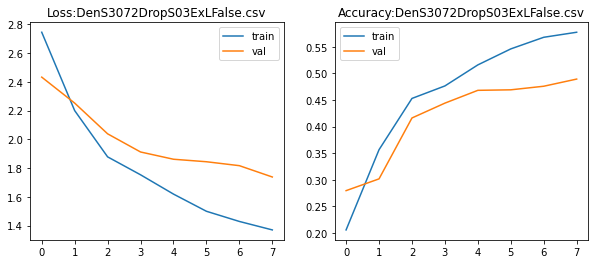

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.167079  2.920859      0.264933  2.483461
1      1  0.295792  2.342231      0.335260  2.196375
2      2  0.384901  2.071580      0.364162  2.162565
3      3  0.435644  1.880314      0.425819  1.948898
4      4  0.469059  1.750303      0.414258  1.948034
5      5  0.508251  1.622654      0.426782  1.957877
6      6  0.525165  1.552171      0.477842  1.784993
7      7  0.537129  1.459918      0.461464  1.819130


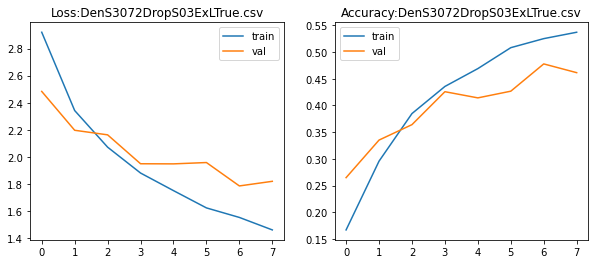

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.192244  2.796058      0.320809  2.400303
1      1  0.332921  2.253048      0.380540  2.157335
2      2  0.400990  2.004481      0.396917  2.040585
3      3  0.455858  1.838846      0.387283  2.050000
4      4  0.481848  1.703195      0.446050  1.922973
5      5  0.524752  1.591820      0.478805  1.803003
6      6  0.528465  1.535715      0.455684  1.884038
7      7  0.554868  1.457143      0.476879  1.849513


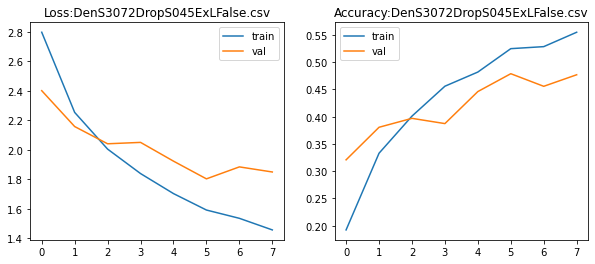

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.131601  3.006376      0.222543  2.604609
1      1  0.266502  2.459546      0.320809  2.272245
2      2  0.339521  2.189602      0.346821  2.178006
3      3  0.370050  2.035416      0.386320  2.058084
4      4  0.411304  1.931130      0.432563  1.962579
5      5  0.441832  1.852382      0.453757  1.904509
6      6  0.463696  1.741884      0.433526  1.905581
7      7  0.488036  1.679731      0.452794  1.814233


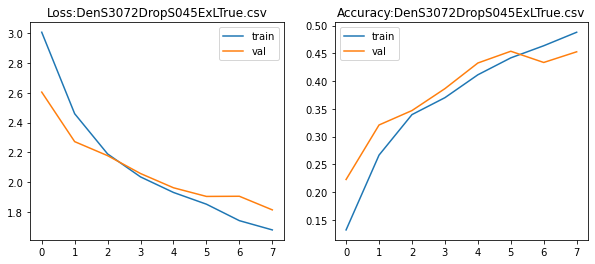

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.200495  2.785054      0.315029  2.398875
1      1  0.360561  2.185582      0.390173  2.131112
2      2  0.422855  1.936590      0.410405  2.030570
3      3  0.461221  1.791761      0.441233  1.916559
4      4  0.489274  1.680389      0.433526  1.891564
5      5  0.509488  1.568397      0.478805  1.780394
6      6  0.531353  1.500209      0.486513  1.764488
7      7  0.573845  1.435285      0.482659  1.801618


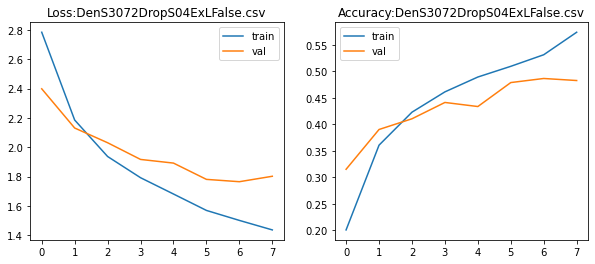

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.147690  2.931261      0.223507  2.555655
1      1  0.277228  2.402494      0.339114  2.214440
2      2  0.346535  2.172040      0.391137  2.070588
3      3  0.389439  1.967305      0.404624  2.032235
4      4  0.420380  1.856513      0.419075  1.927915
5      5  0.462459  1.720479      0.451830  1.896863
6      6  0.492987  1.652449      0.492293  1.741219
7      7  0.513614  1.547870      0.478805  1.810624


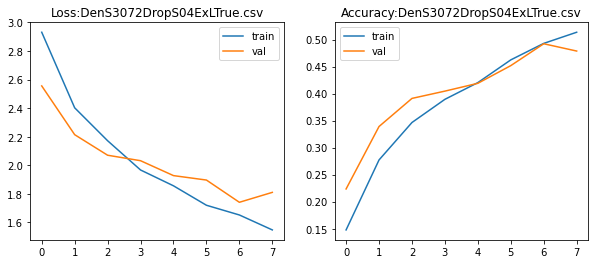

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.214934  2.738197      0.289981  2.418071
1      1  0.356436  2.156951      0.381503  2.138025
2      2  0.423680  1.904378      0.381503  2.029567
3      3  0.464934  1.767829      0.425819  1.965527
4      4  0.511964  1.638894      0.481696  1.776173
5      5  0.545380  1.496746      0.470135  1.809829
6      6  0.545380  1.473610      0.475915  1.763005
7      7  0.594059  1.333314      0.473025  1.791280


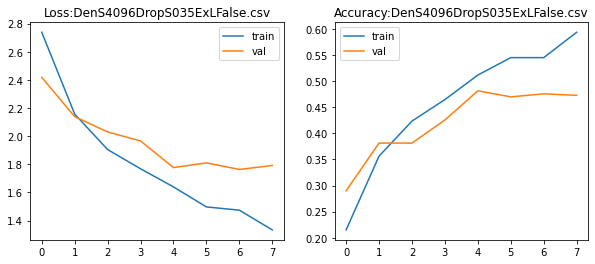

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.149752  2.974312      0.245665  2.545113
1      1  0.301980  2.342399      0.314066  2.280806
2      2  0.358086  2.108992      0.396917  2.102622
3      3  0.416254  1.921600      0.364162  2.088137
4      4  0.459158  1.783756      0.372832  2.042491
5      5  0.475248  1.684865      0.454721  1.844374
6      6  0.512376  1.575073      0.473025  1.795152
7      7  0.523927  1.499650      0.490366  1.709580


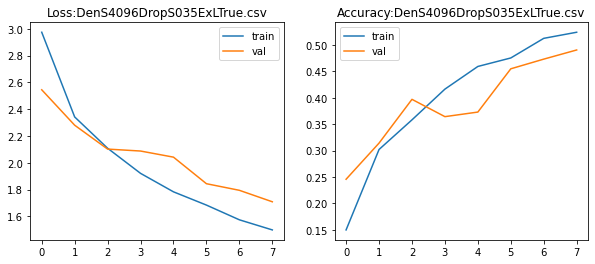

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.209983  2.775700      0.325626  2.331127
1      1  0.375000  2.120017      0.365125  2.162080
2      2  0.427805  1.896459      0.424856  1.977725
3      3  0.494637  1.696012      0.448940  1.920794
4      4  0.519389  1.599679      0.463391  1.836693
5      5  0.550743  1.481022      0.470135  1.890359
6      6  0.569307  1.384989      0.471098  1.824522
7      7  0.578795  1.363204      0.490366  1.771017


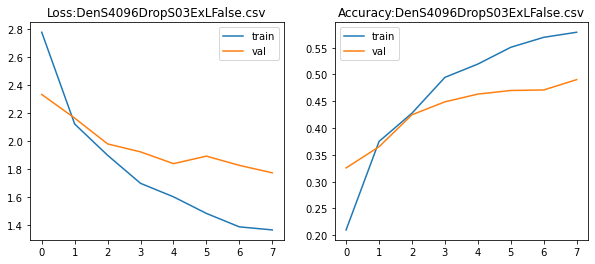

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.165017  2.919756      0.250482  2.484020
1      1  0.305693  2.307426      0.337187  2.217788
2      2  0.382426  2.083510      0.368979  2.111328
3      3  0.424917  1.884564      0.434489  1.990650
4      4  0.459983  1.752132      0.426782  1.997646
5      5  0.503300  1.638892      0.446050  1.856302
6      6  0.522277  1.553718      0.444123  1.791072
7      7  0.544554  1.496617      0.475915  1.758473


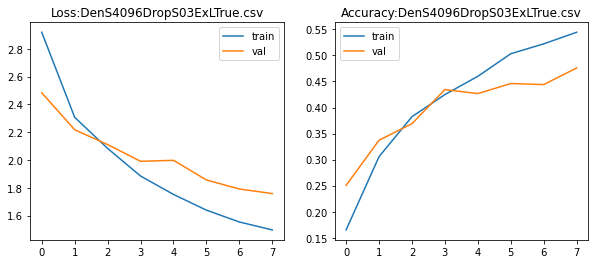

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.202970  2.802378      0.298651  2.418415
1      1  0.344884  2.223234      0.346821  2.219425
2      2  0.400578  1.984046      0.405588  2.005203
3      3  0.436056  1.827836      0.429672  1.936649
4      4  0.492574  1.693866      0.441233  1.938842
5      5  0.502888  1.602560      0.448940  1.848015
6      6  0.531353  1.510365      0.463391  1.796797
7      7  0.538366  1.485967      0.480732  1.733822


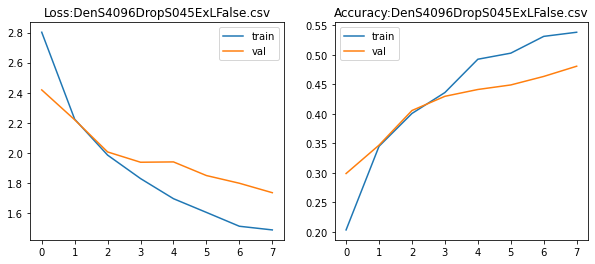

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.162129  2.946700      0.293834  2.477160
1      1  0.276815  2.393905      0.350674  2.212389
2      2  0.355611  2.157955      0.401734  2.057204
3      3  0.370875  2.030836      0.362235  2.154770
4      4  0.408828  1.901748      0.408478  2.020951
5      5  0.460809  1.790676      0.443160  1.863429
6      6  0.485561  1.671151      0.464355  1.793142
7      7  0.499587  1.617849      0.440270  1.808949


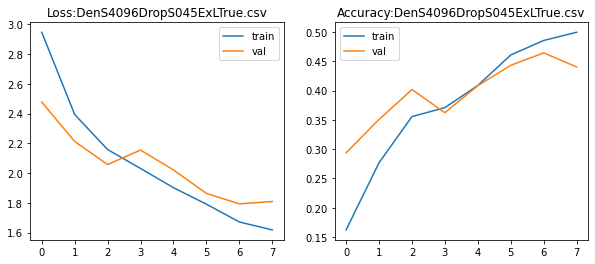

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.209983  2.776362      0.288054  2.481526
1      1  0.365512  2.164838      0.364162  2.163629
2      2  0.422030  1.944511      0.420039  1.985910
3      3  0.459983  1.800051      0.434489  1.899279
4      4  0.499587  1.653255      0.412331  1.967240
5      5  0.516914  1.555651      0.465318  1.785153
6      6  0.546617  1.495321      0.446050  1.821225
7      7  0.570132  1.418895      0.451830  1.794834


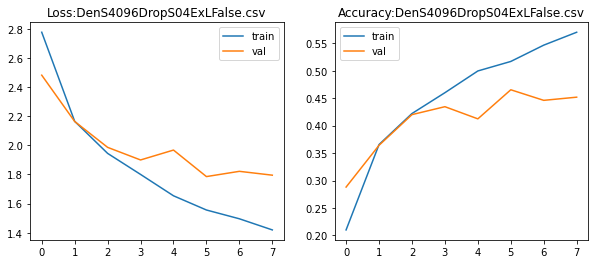

   epoch  accuracy      loss  val_accuracy  val_loss
0      0  0.176155  2.905310      0.286127  2.504651
1      1  0.287129  2.371305      0.354528  2.216637
2      2  0.353960  2.105021      0.382466  2.065619
3      3  0.413779  1.930485      0.406551  1.952499
4      4  0.447195  1.822534      0.423892  1.920839
5      5  0.479785  1.701773      0.434489  1.855149
6      6  0.509076  1.623082      0.438343  1.844169
7      7  0.528053  1.542498      0.465318  1.807206


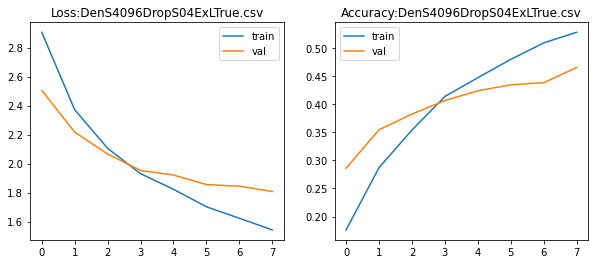

In [140]:
# plot acc-loss 
for d in data:
    print(data[d])
    acc = np.array(data[d]['accuracy'])
    loss = np.array(data[d]['loss'])
    val_acc = np.array(data[d]['val_accuracy'])
    val_loss = np.array(data[d]['val_loss'])
    plot_acc_loss(acc,loss,val_acc,val_loss,epochs_test_size,d)

In [141]:
# last epochs analysis

max_acc = 0
max_acc_f = None

max_val_acc = 0
max_val_acc_f = None

min_loss = 10
min_loss_f = None

min_val_loss = 10
min_val_loss_f = None

min_acc_gap = 10
min_acc_gap_f = None

min_loss_gap = 10
min_loss_gap_f = None

accs = []
losses = []
val_accs = []
val_losses = []
acc_gaps = []
loss_gaps = []

for d in data:
    print("***   " + d + "   ***\n")
    acc = np.array(data[d]['accuracy'])
    loss = np.array(data[d]['loss'])
    val_acc = np.array(data[d]['val_accuracy'])
    val_loss = np.array(data[d]['val_loss'])
    acc_gap = math.fabs(acc[-1] - val_acc[-1])
    loss_gap = math.fabs(loss[-1] - val_loss[-1])
    
    accs.append(acc[-1])
    val_accs.append(val_acc[-1])
    losses.append(loss[-1])
    val_losses.append(val_loss[-1])
    acc_gaps.append(acc_gap)
    loss_gaps.append(loss_gap)
    
    if acc[-1] > max_acc:
        max_acc = acc[-1]
        max_acc_f = str(d)
    if val_acc[-1] > max_val_acc:
        max_val_acc = val_acc[-1]
        max_val_acc_f = str(d)
    if min_loss > loss[-1]:
        min_loss = loss[-1]
        min_loss_f = str(d)
    if min_val_loss > val_loss[-1]:
        min_val_loss = val_loss[-1]
        min_val_loss_f = str(d)
    if min_acc_gap > acc_gap:
        min_acc_gap = acc_gap
        min_acc_gap_f = str(d)
    if min_loss_gap > loss_gap:
        min_loss_gap = loss_gap
        min_loss_gap_f = str(d)
    
    print("Acc:" + str(acc[-1]) + "\n")
    print("Val_acc:" + str(val_acc[-1]) + "\n")
    print("Loss:" + str(loss[-1]) + "\n")
    print("Val_loss:" + str(val_loss[-1]) + "\n")
    print("Acc-Val_acc gap:" + str(acc_gap) + "\n")
    print("Loss-Val_loss gap:" + str(loss_gap))
    print()

***   DenS2048DropS035ExLFalse.csv   ***

Acc:0.5676567554473877

Val_acc:0.4942196607589721

Loss:1.4345346689224243

Val_loss:1.775947093963623

Acc-Val_acc gap:0.07343709468841558

Loss-Val_loss gap:0.34141242504119873

***   DenS2048DropS035ExLTrue.csv   ***

Acc:0.5387789011001587

Val_acc:0.4797687828540802

Loss:1.511481523513794

Val_loss:1.830243229866028

Acc-Val_acc gap:0.05901011824607849

Loss-Val_loss gap:0.3187617063522341

***   DenS2048DropS03ExLFalse.csv   ***

Acc:0.5767326951026917

Val_acc:0.4730250537395477

Loss:1.3999831676483154

Val_loss:1.792822241783142

Acc-Val_acc gap:0.10370764136314398

Loss-Val_loss gap:0.39283907413482666

***   DenS2048DropS03ExLTrue.csv   ***

Acc:0.5338283777236938

Val_acc:0.4778420031070709

Loss:1.4829286336898804

Val_loss:1.742498517036438

Acc-Val_acc gap:0.055986374616622925

Loss-Val_loss gap:0.2595698833465576

***   DenS2048DropS045ExLFalse.csv   ***

Acc:0.5297029614448547

Val_acc:0.4816955626010895

Loss:1.5373345613479

In [142]:
print("Max acc:" + str(max_acc) + " Model:" + max_acc_f)
print("Max val_acc:" + str(max_val_acc) + " Model:" + max_val_acc_f)
print("Min loss:" + str(min_loss) + " Model:" + min_loss_f)
print("Min val_loss:" + str(min_val_loss) + " Model:" + min_val_loss_f)
print("Min acc gap:" + str(min_acc_gap) + " Model:" + min_acc_gap_f)
print("Min loss gap:" + str(min_loss_gap) + " Model:" + min_loss_gap_f)

Max acc:0.594059407711029 Model:DenS4096DropS035ExLFalse.csv
Max val_acc:0.4961464405059814 Model:DenS3072DropS035ExLFalse.csv
Min loss:1.333314299583435 Model:DenS4096DropS035ExLFalse.csv
Min val_loss:1.7095803022384644 Model:DenS4096DropS035ExLTrue.csv
Min acc gap:0.00042685866355895996 Model:DenS2048DropS045ExLTrue.csv
Min loss gap:0.13450205326080322 Model:DenS3072DropS045ExLTrue.csv


In [146]:
model_names = [d for d in data]

In [149]:
len(model_names), len(accs)

(24, 24)

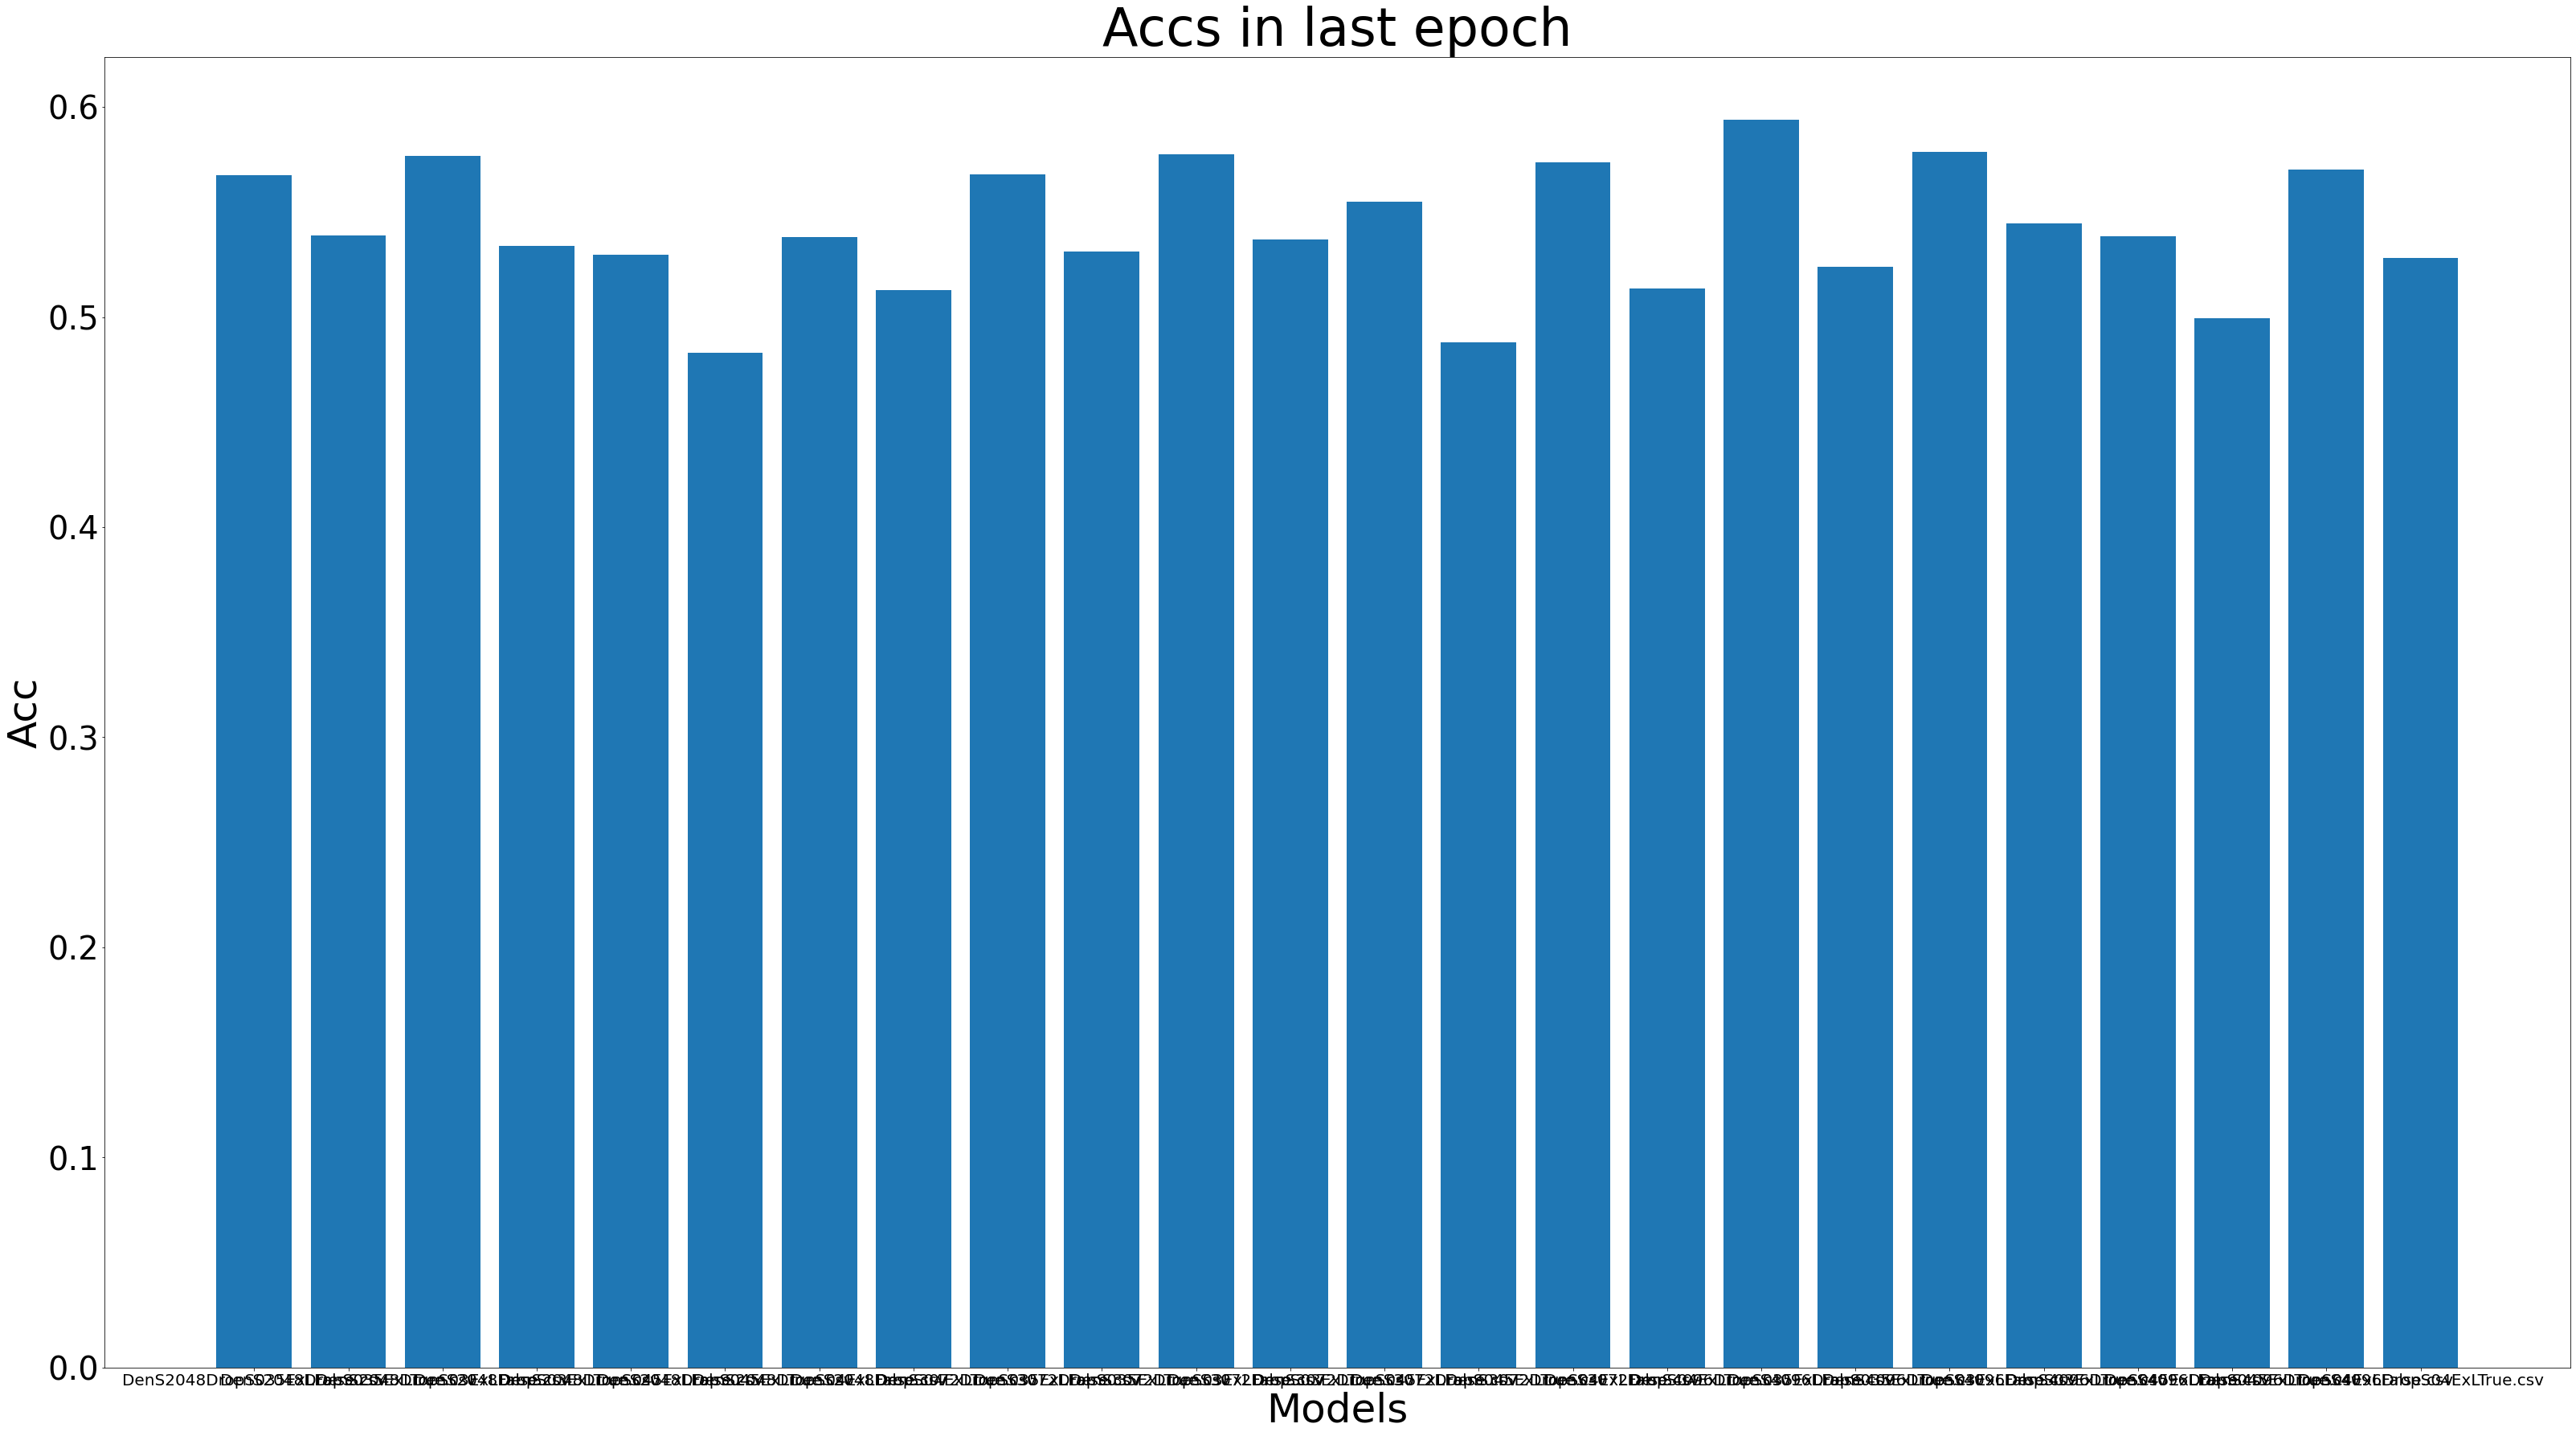

In [155]:
plt.figure(figsize=(55,30))
plt.title('Accs in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Acc', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,accs)
plt.show()

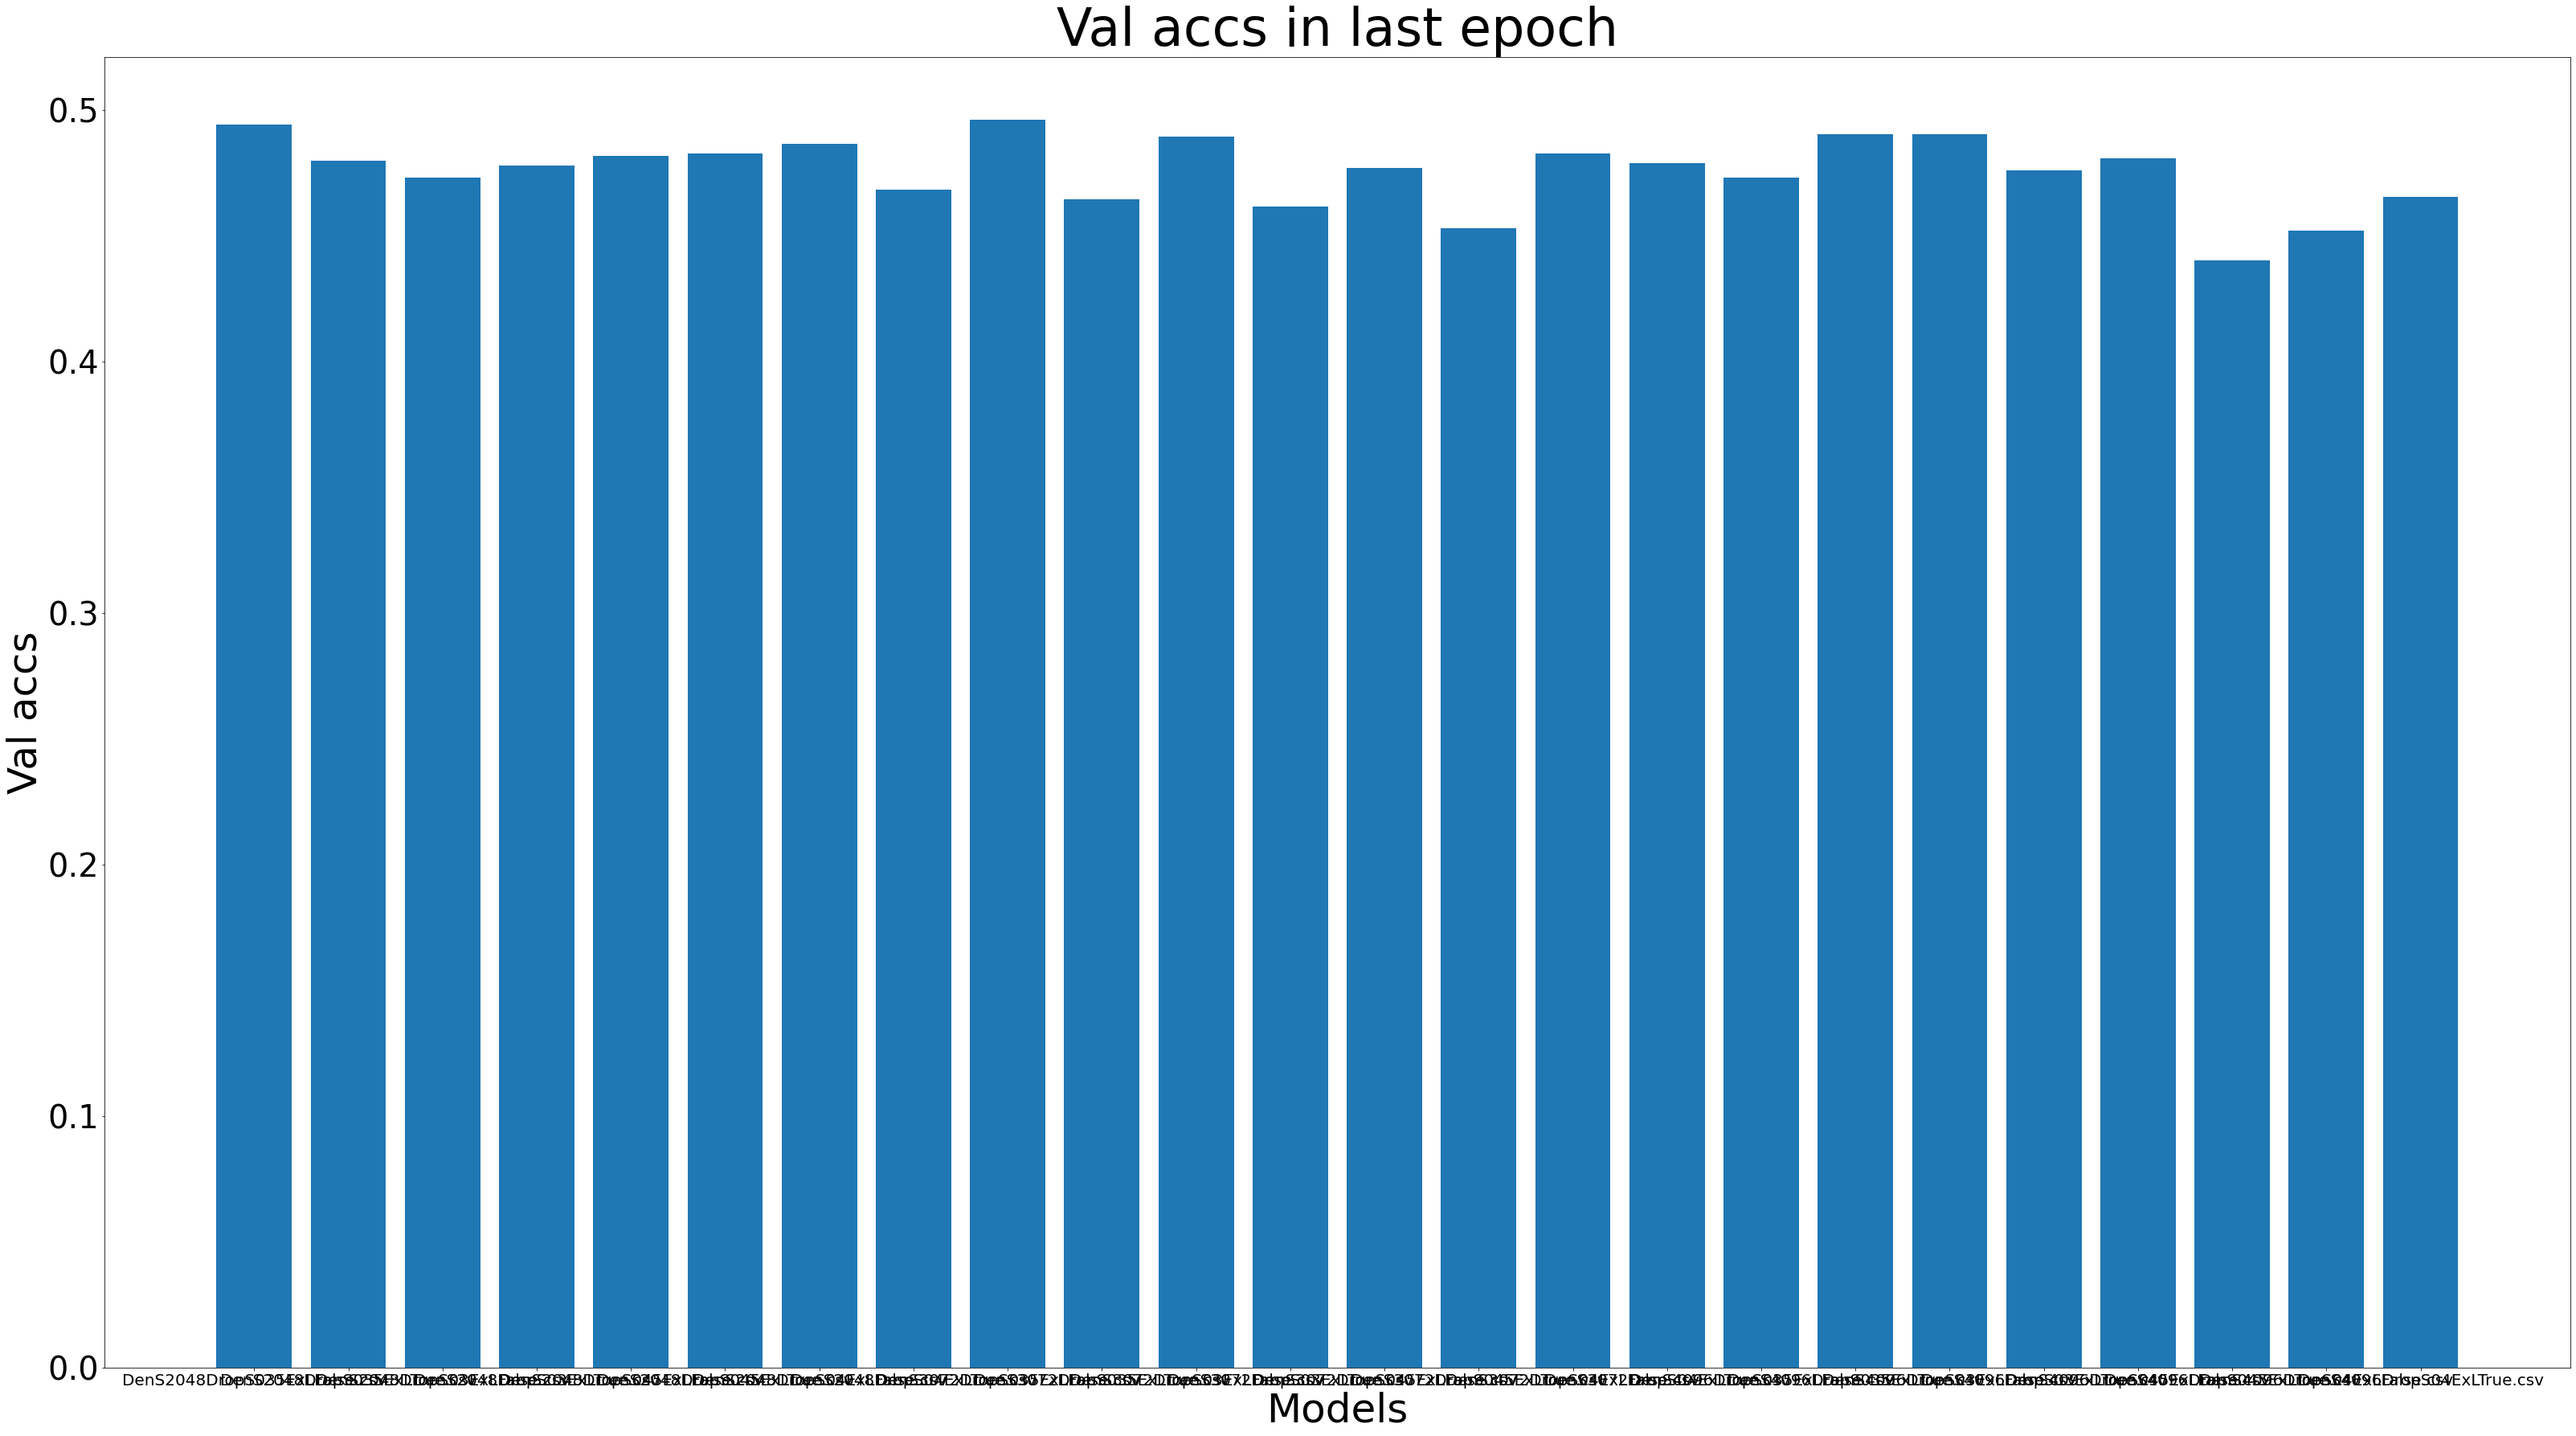

In [159]:
plt.figure(figsize=(55,30))
plt.title('Val accs in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Val accs', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,val_accs)
plt.show()

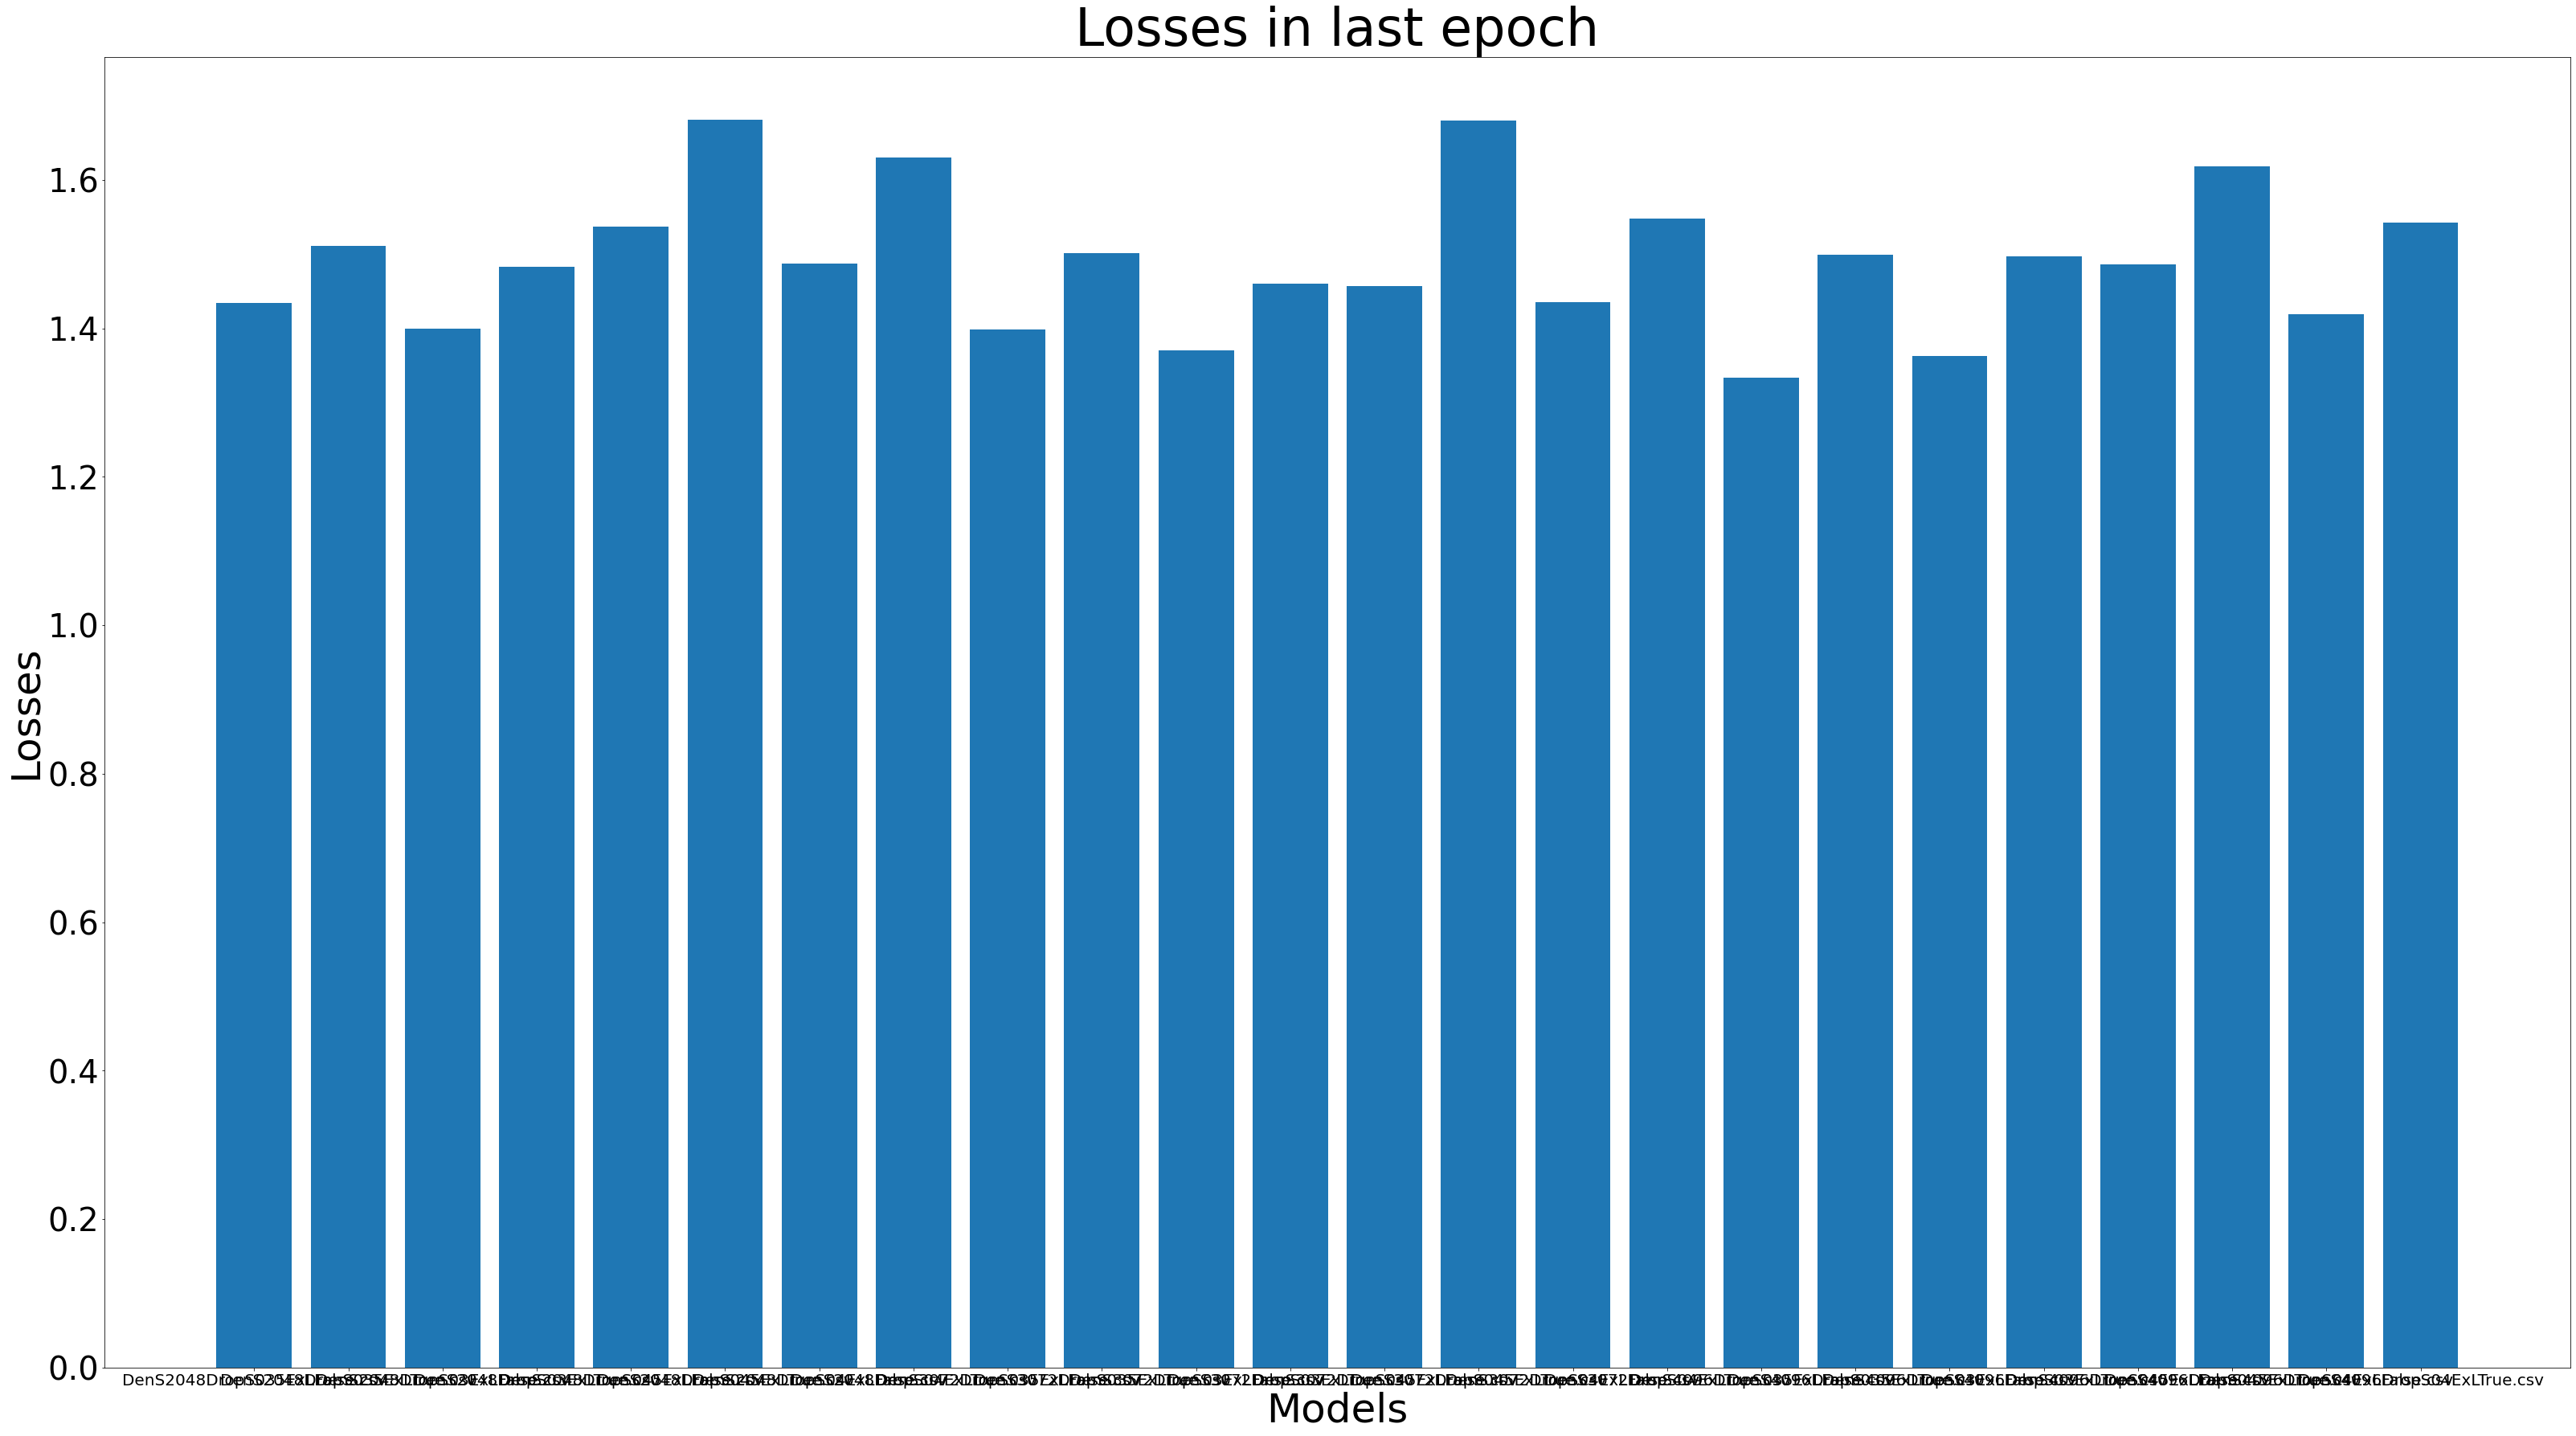

In [161]:
plt.figure(figsize=(55,30))
plt.title('Losses in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Losses', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,losses)
plt.show()

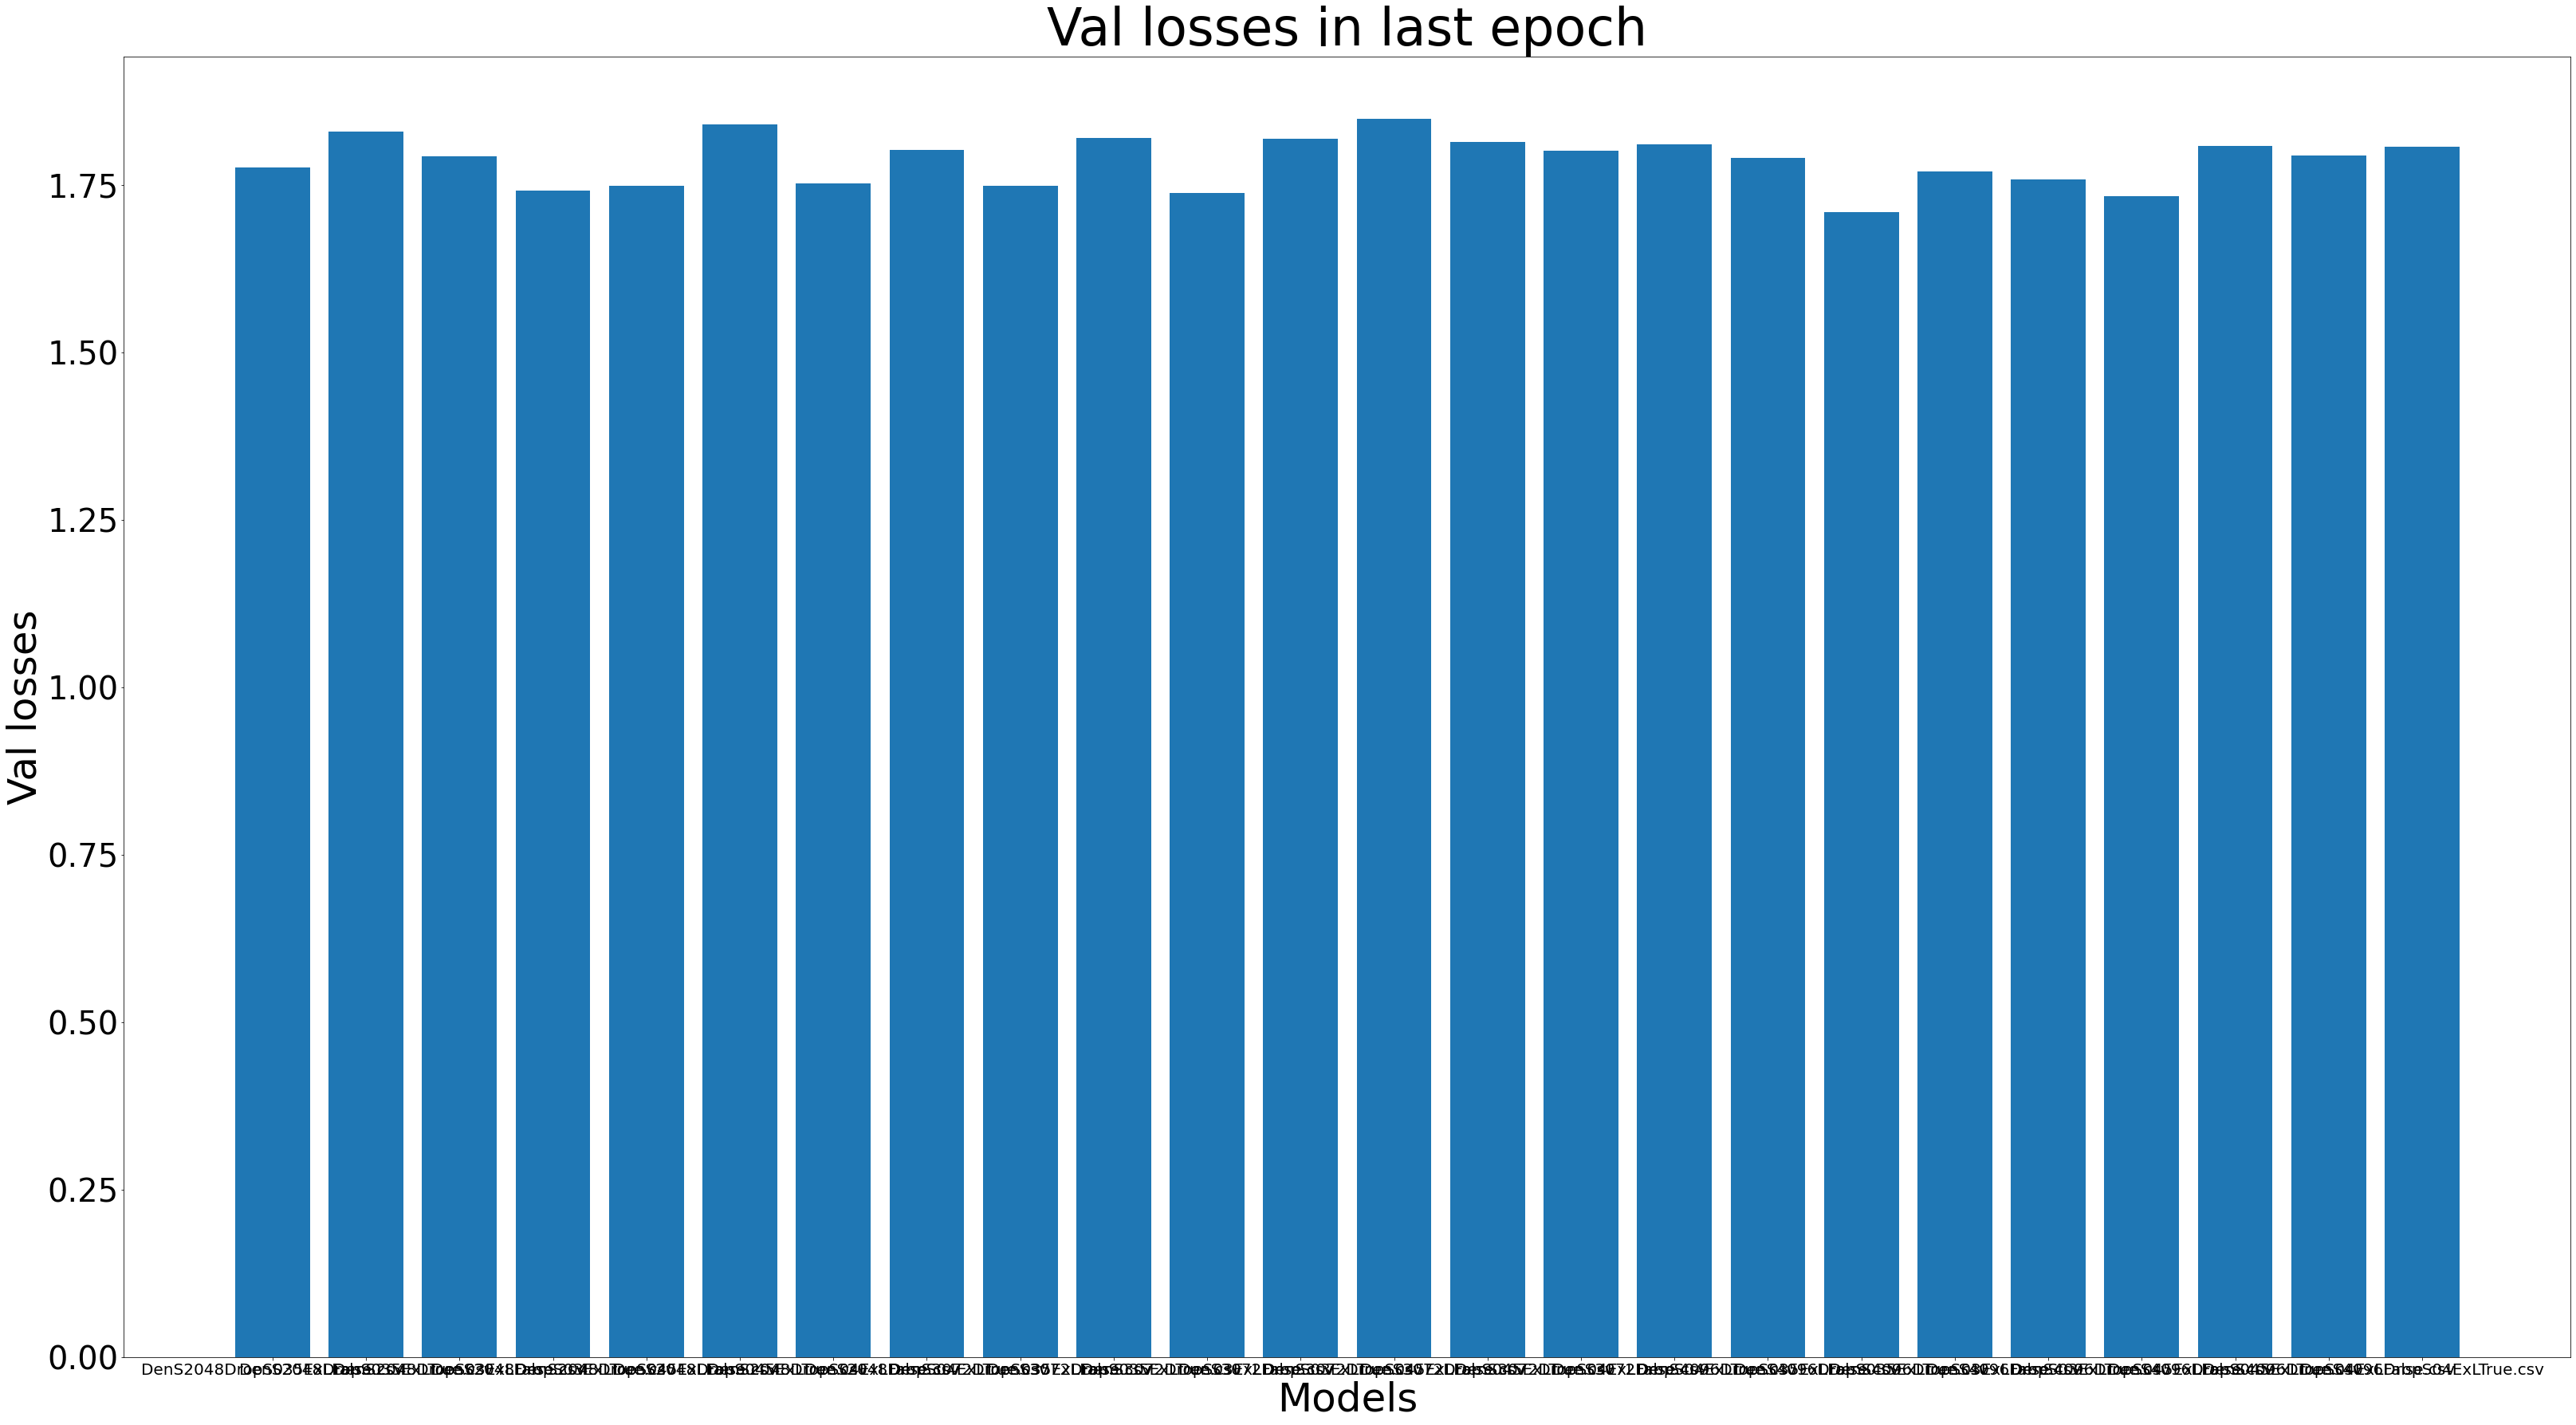

In [162]:
plt.figure(figsize=(55,30))
plt.title('Val losses in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Val losses', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,val_losses)
plt.show()

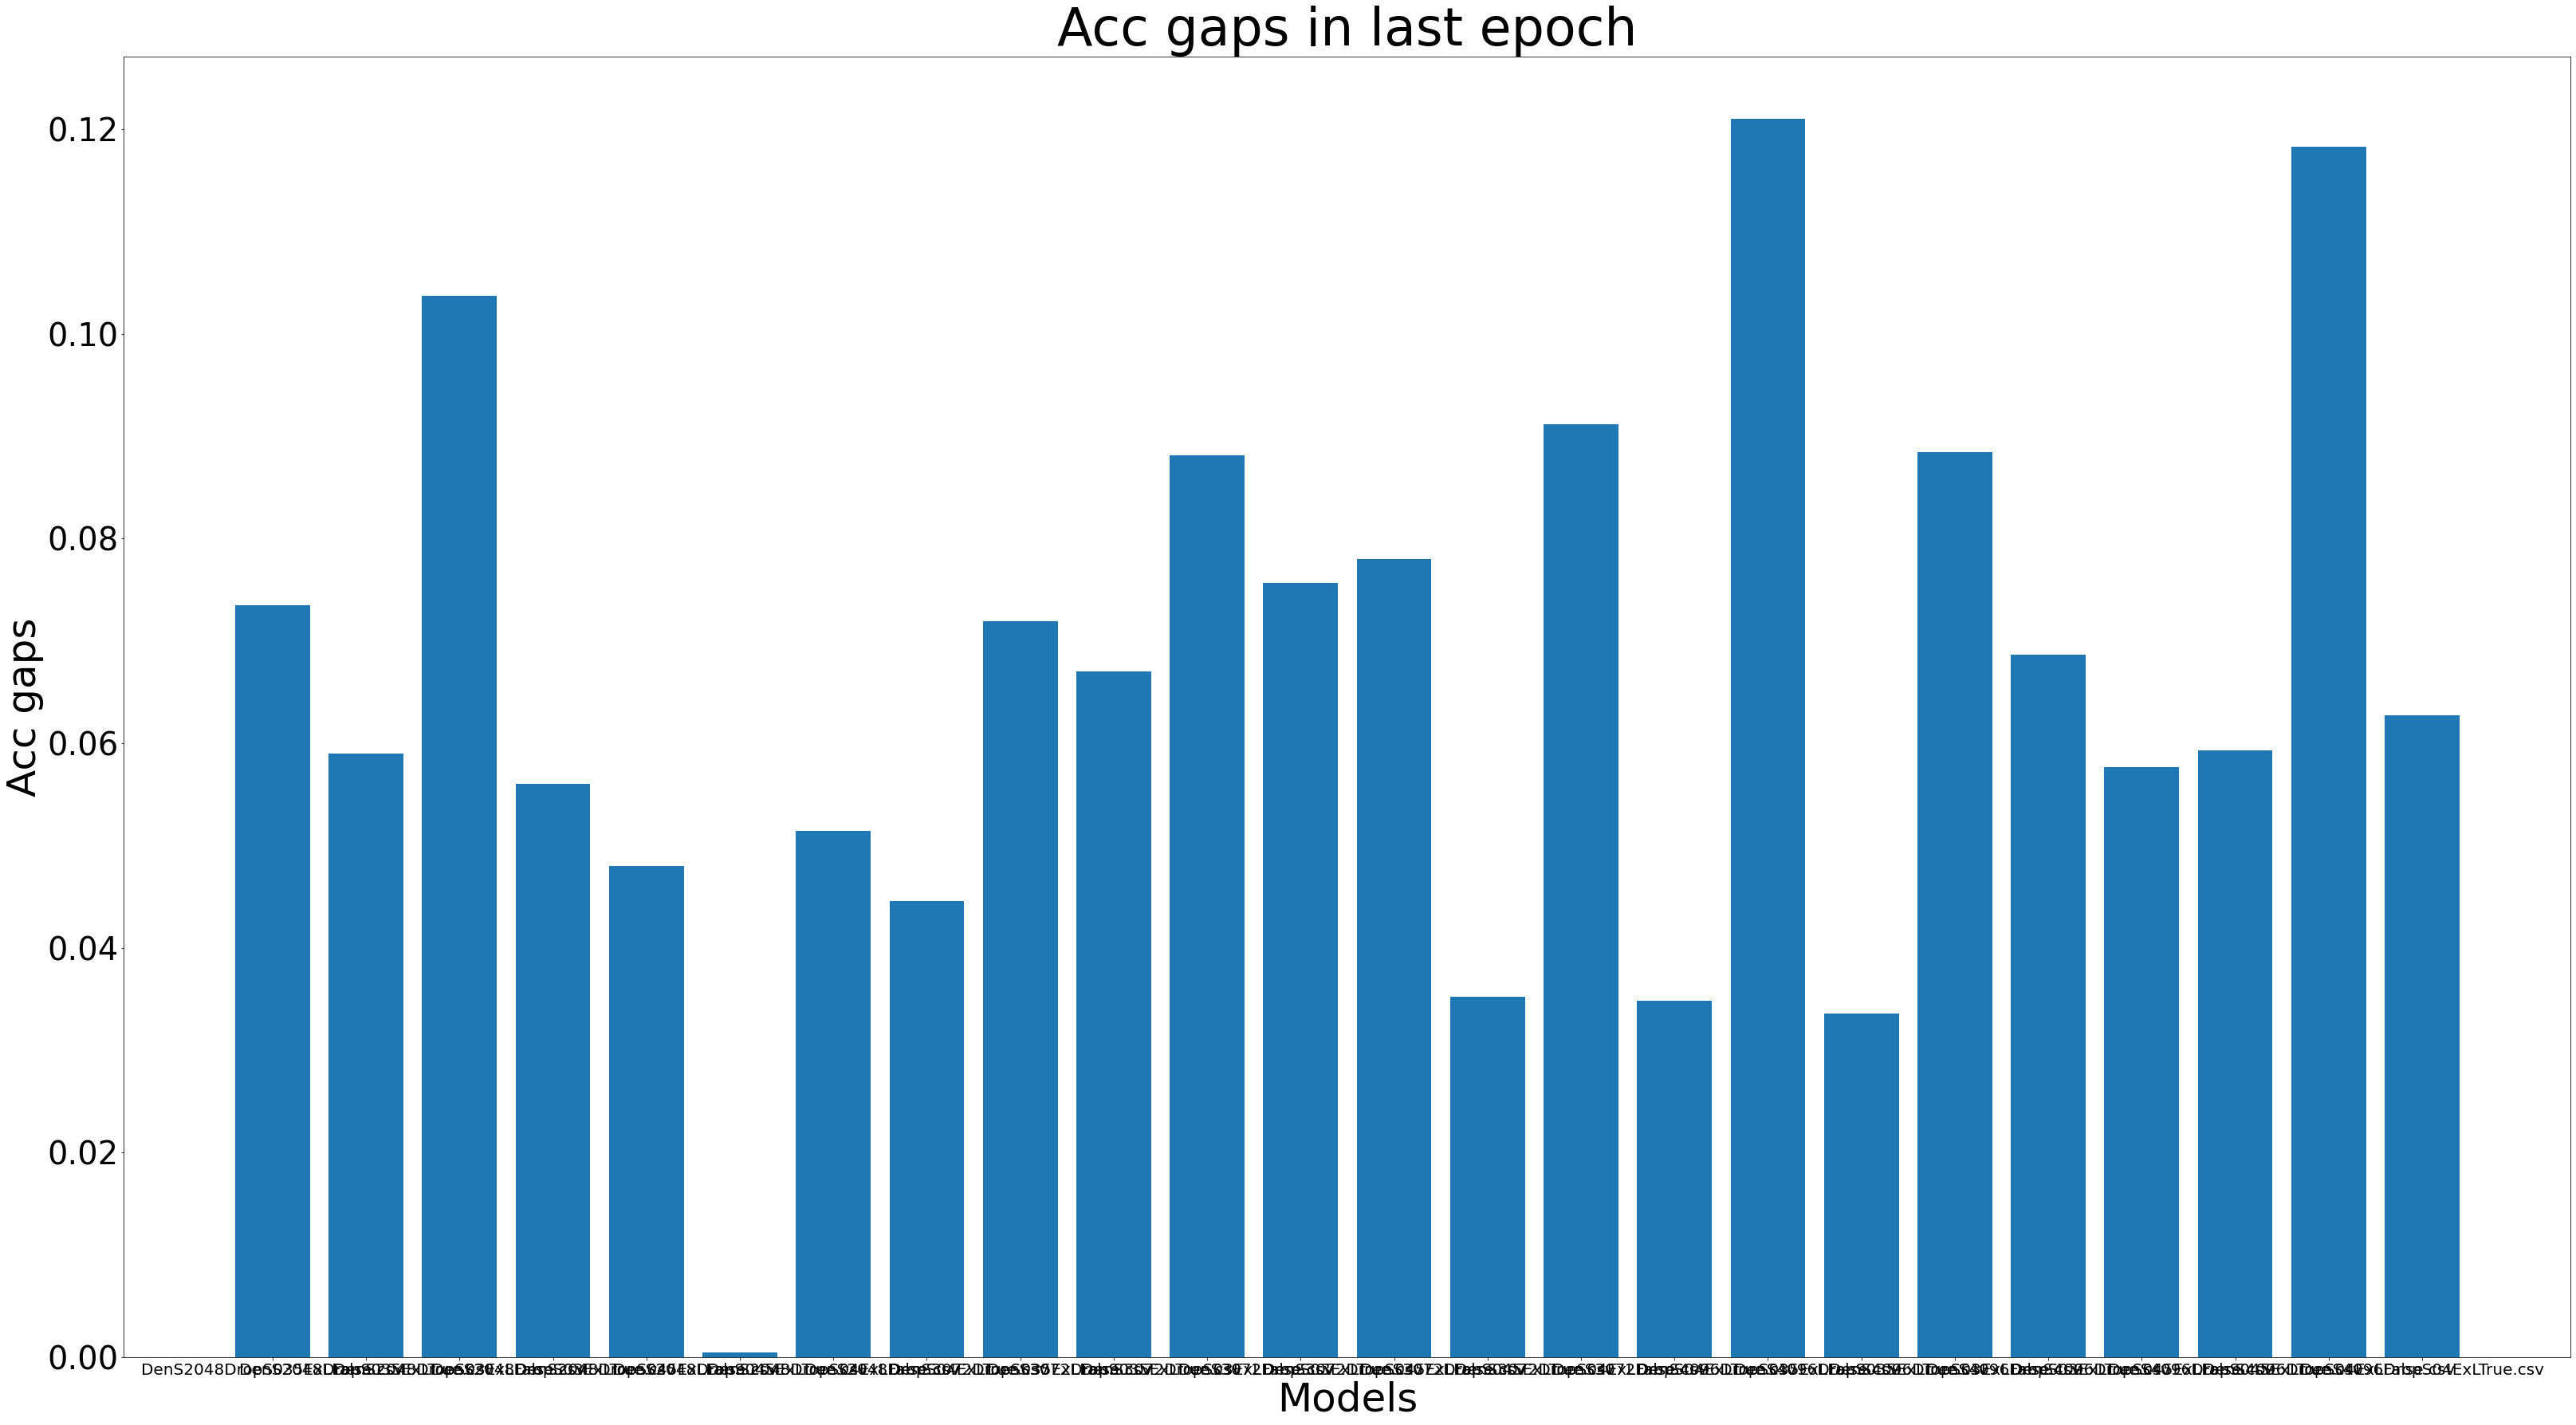

In [163]:
plt.figure(figsize=(55,30))
plt.title('Acc gaps in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Acc gaps', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,acc_gaps)
plt.show()

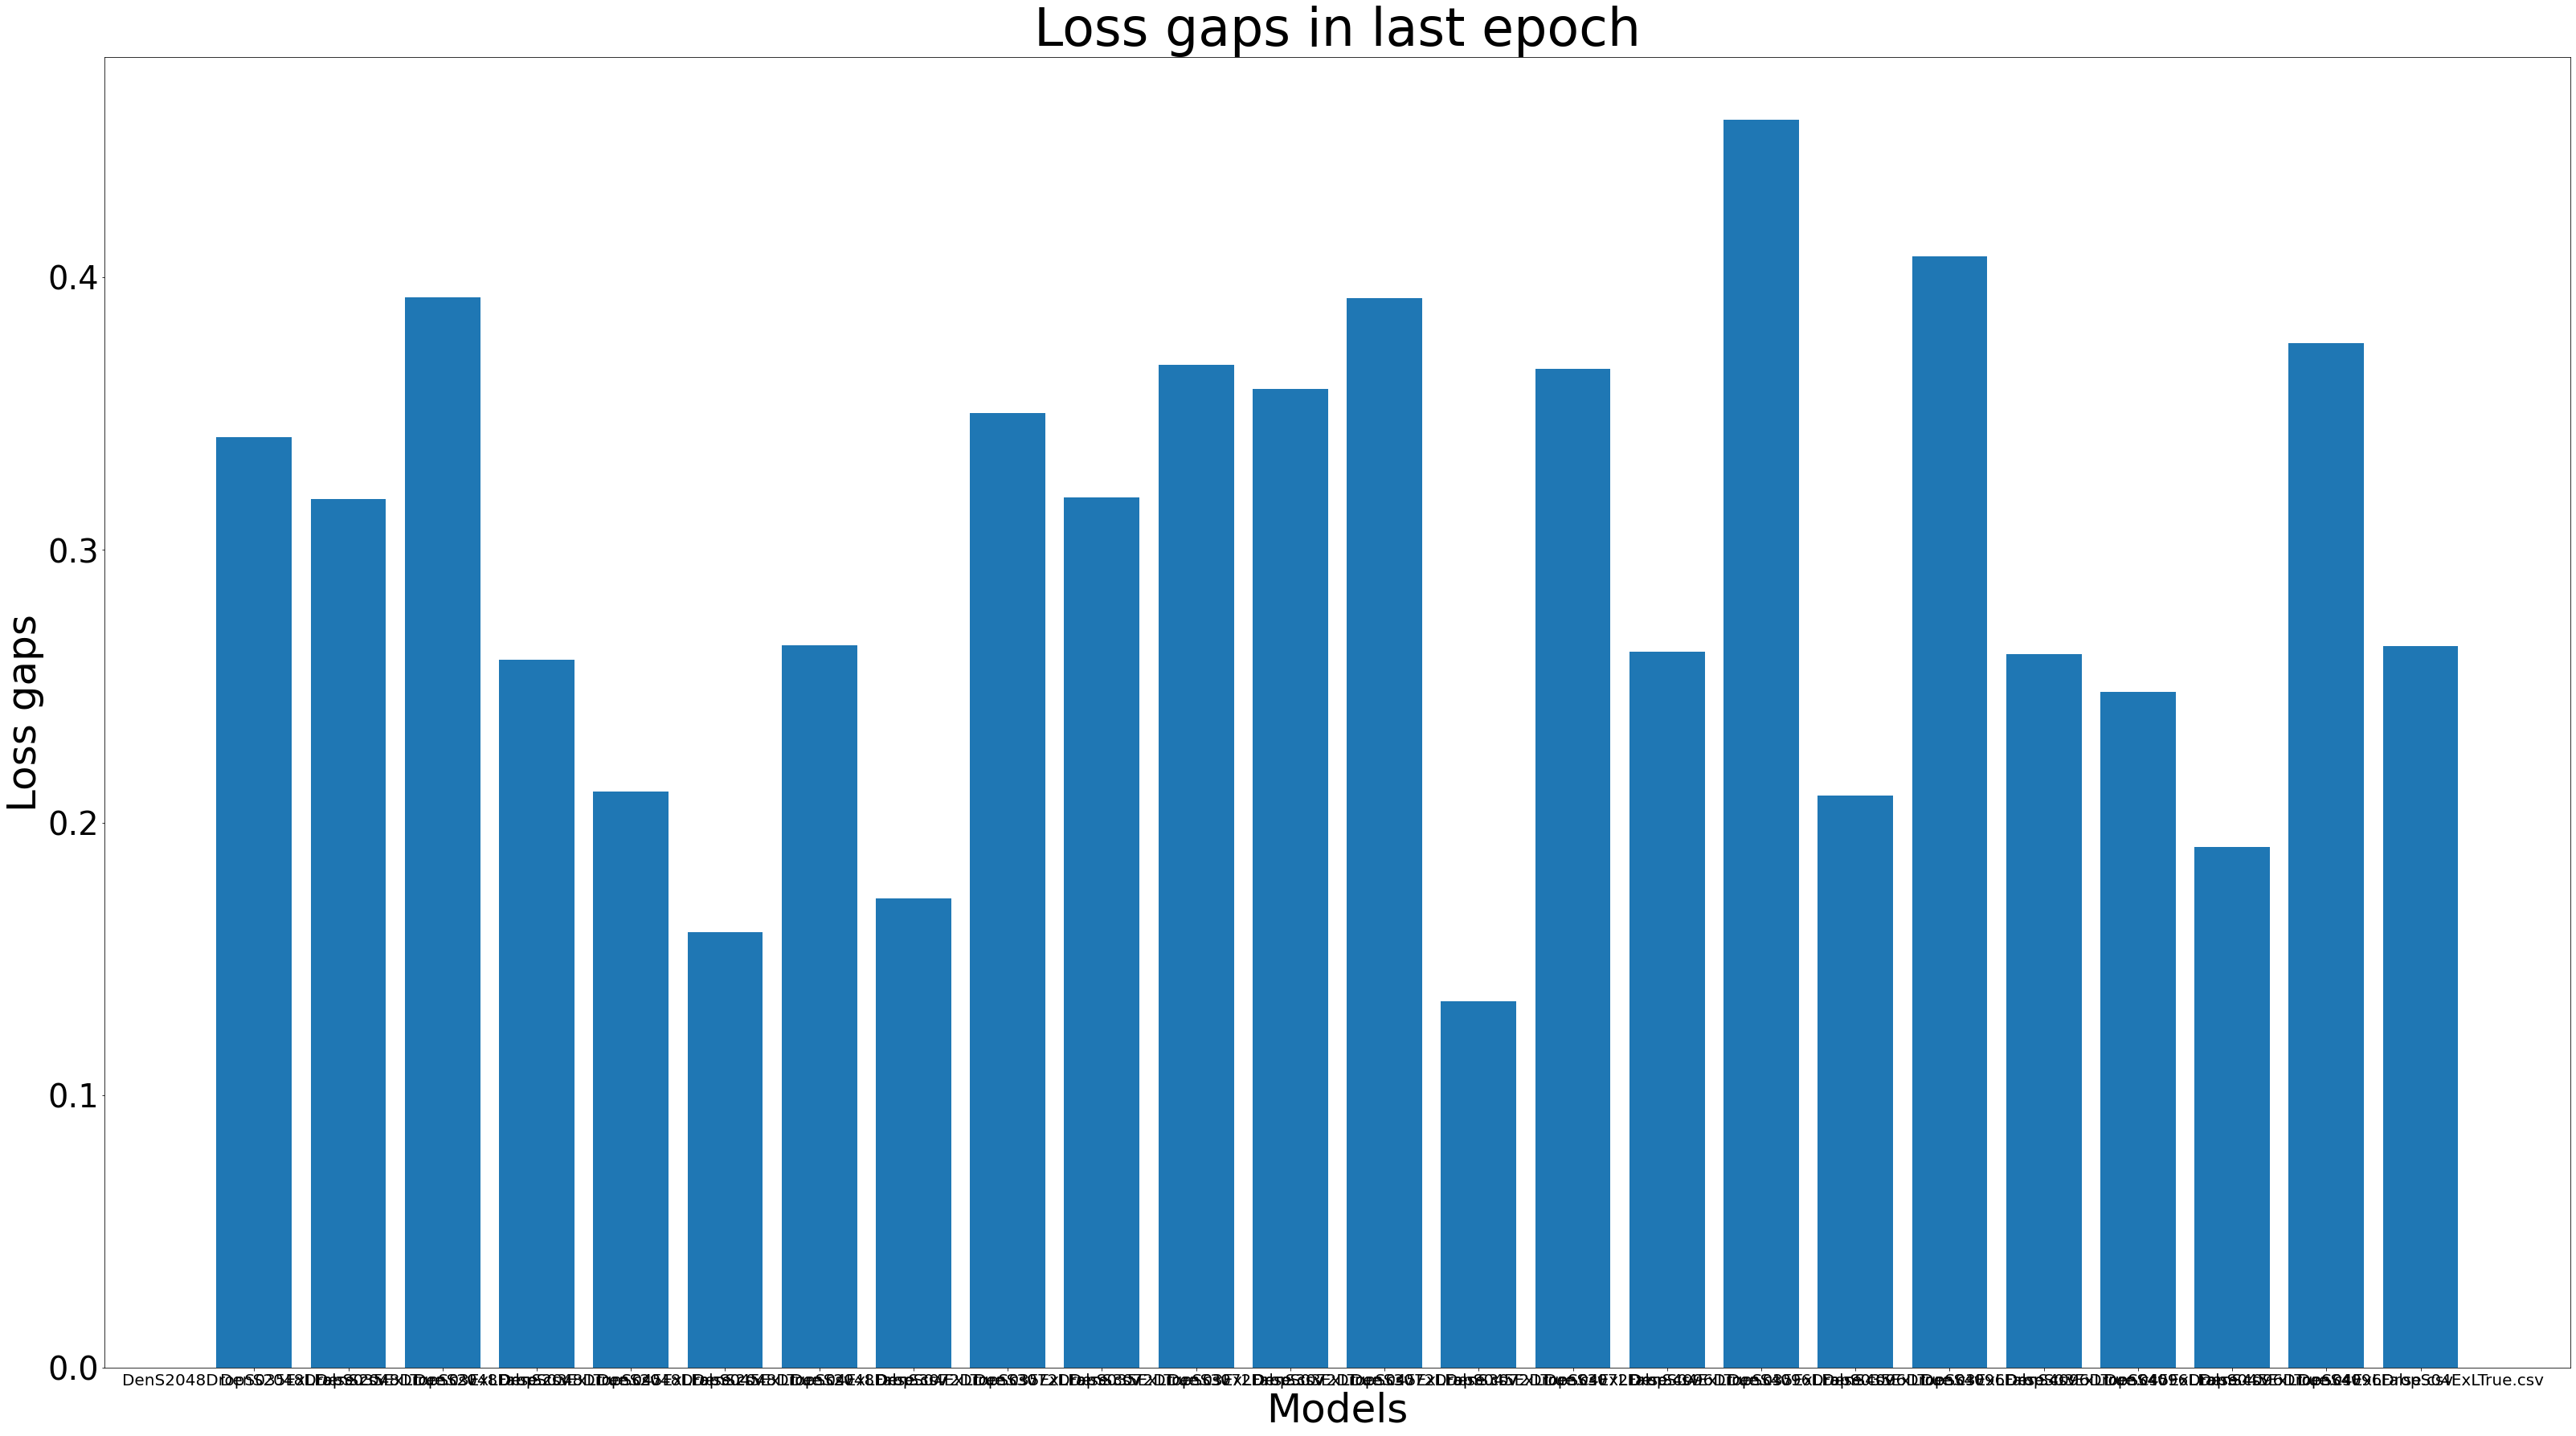

In [164]:
plt.figure(figsize=(55,30))
plt.title('Loss gaps in last epoch', fontsize=65)
plt.xlabel('Models', fontsize=50)
plt.ylabel('Loss gaps', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(model_names,loss_gaps)
plt.show()

In [165]:
model_names[8]

'DenS3072DropS035ExLFalse.csv'

In [167]:
# We will take model DenS3072DropS035ExLFalse because the model has maximal vall acc of 0.4961464405059814 and his acc 
# is 3% lower than max acc model, taken mostly by visual analysis...
# So final model hax Dense 3072 with Dropout 0.35 and with no extra layers...